# Airbnb Pricing Prediction: Milestone 3
**James Gearheart**<br>
**Danny Zhuang**<br>
**Bob Saludo**<br>
**Ryan Wallace**<br><br>
**Harvard University**<br>
**Fall 2016**<br>
**TF: Christine Hwang**<br>
**Due Date: ** Saturday, November 5th, 2016

---

In [46]:
# import necessary libraries
import csv
import datetime
import operator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LinReg
%matplotlib inline

---

## Read and Format Data

In [47]:
# remove commas from prices in calendar CSV
with open('datasets/calendar.csv', 'rb') as f, open('datasets/calendar_cleaned.csv', 'wb') as g:
    writer = csv.writer(g, delimiter=',')
    for line in f:
        # split into four columns
        row = line.split(',', 3)
        writer.writerow(row)
        
# read the three datasets
listings_df = pd.read_csv('datasets/listings.csv', delimiter=',')
reviews_df = pd.read_csv('datasets/reviews.csv', delimiter=',')
calendar_df = pd.read_csv('datasets/calendar_cleaned.csv')

In [48]:
print 'listings dataframe: \n'
listings_df.head()

listings dataframe: 



,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,1069266,2.015010e+13,1/2/15,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,4/10/13,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",...,4/28/13,12/17/14,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,1/5/14,12/29/14,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2
2,2061725,2.015010e+13,1/2/15,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,1/5/13,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",...,2/4/14,12/29/14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,44974,2.015010e+13,1/3/15,Charming Bright West Village Studio,https://a1.muscache.com/pictures/20489905/larg...,198425,Sara,8/11/10,https://a0.muscache.com/ic/users/198425/profil...,"Greenwich Ave, New York, NY 10011, United States",...,10/8/10,10/30/14,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,4701675,2.015010e+13,1/2/15,Charming Apartment in Chelsea,https://a2.muscache.com/pictures/60588955/larg...,22590025,Charles,10/15/14,https://a2.muscache.com/ic/users/22590025/prof...,"West 22nd Street, New York, NY 10011, United S...",...,12/8/14,12/8/14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1


In [49]:
print 'reviews dataframe: \n'
reviews_df.head()

reviews dataframe: 



,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1180670,14705995,2014-06-24,10875598,Gregory,"Ok, if you like the location and don't mind an..."
1,4457617,24432844,2014-12-28,24502047,Amber,"Kleine süße WG, super gelegen, sehr freundlich..."
2,722394,9248781,2013-12-16,6821360,Giri,Extremely disappointed.
3,4074444,23983183,2014-12-15,8822691,Wendy,Exactly as described.
4,68046,11797670,2014-04-15,12231047,Virginie,"Appartement très sympa, accueillant. A quelque..."


In [50]:
print 'calendar dataframe: \n'
calendar_df.head()

calendar dataframe: 



,"""listing_id""","""date""","""available""","""price"""
0,3604481,"""2015-01-01""",t,$600.00\n
1,3604481,"""2015-01-02""",t,$600.00\n
2,3604481,"""2015-01-03""",t,$600.00\n
3,3604481,"""2015-01-04""",t,$600.00\n
4,3604481,"""2015-01-05""",t,$600.00\n


In [51]:
# method to smartly convert price strings to floats
def convert_float(val):
    try:
        if type(val) == float:
            return val
        else:
            return float(val.strip('[\$\n]').replace(',',''))
    except ValueError:
        return np.nan

In [52]:
# fix wonky formatting of data and field names
# remove surronding parens and newlines from column names
old_columns = listings_df.columns.values 
new_columns = [col.replace('"', '').replace('\n','') for col in old_columns] 
listings_df.columns = new_columns

old_columns = reviews_df.columns.values 
new_columns = [col.replace('"', '').replace('\n','') for col in old_columns] 
reviews_df.columns = new_columns

old_columns = calendar_df.columns.values 
new_columns = [col.replace('"', '').replace('\n','') for col in old_columns] 
calendar_df.columns = new_columns

# remove parens around date in calendar_df
calendar_df['date'] = calendar_df['date'].apply(lambda x: x.replace('"', ''))

# change t and f to 1 and 0 in calendar_df
calendar_df['available'] = calendar_df['available'].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else np.nan)

# change string types to floats when possible
listings_df['price'] = listings_df['price'].apply(lambda x: convert_float(x))
listings_df['weekly_price'] = listings_df['weekly_price'].apply(lambda x: convert_float(x))
listings_df['monthly_price'] = listings_df['monthly_price'].apply(lambda x: convert_float(x))
calendar_df['price'] = calendar_df['price'].apply(lambda x: convert_float(x))

In [53]:
print 'listings dataframe: \n'
listings_df.head()

listings dataframe: 



,id,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,1069266,2.015010e+13,1/2/15,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,4/10/13,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",...,4/28/13,12/17/14,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,1/5/14,12/29/14,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2
2,2061725,2.015010e+13,1/2/15,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,1/5/13,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",...,2/4/14,12/29/14,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,44974,2.015010e+13,1/3/15,Charming Bright West Village Studio,https://a1.muscache.com/pictures/20489905/larg...,198425,Sara,8/11/10,https://a0.muscache.com/ic/users/198425/profil...,"Greenwich Ave, New York, NY 10011, United States",...,10/8/10,10/30/14,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,4701675,2.015010e+13,1/2/15,Charming Apartment in Chelsea,https://a2.muscache.com/pictures/60588955/larg...,22590025,Charles,10/15/14,https://a2.muscache.com/ic/users/22590025/prof...,"West 22nd Street, New York, NY 10011, United S...",...,12/8/14,12/8/14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1


In [54]:
print 'reviews dataframe: \n'
reviews_df.head()

reviews dataframe: 



,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1180670,14705995,2014-06-24,10875598,Gregory,"Ok, if you like the location and don't mind an..."
1,4457617,24432844,2014-12-28,24502047,Amber,"Kleine süße WG, super gelegen, sehr freundlich..."
2,722394,9248781,2013-12-16,6821360,Giri,Extremely disappointed.
3,4074444,23983183,2014-12-15,8822691,Wendy,Exactly as described.
4,68046,11797670,2014-04-15,12231047,Virginie,"Appartement très sympa, accueillant. A quelque..."


In [55]:
print 'calendar dataframe: \n'
calendar_df.head()

calendar dataframe: 



,listing_id,date,available,price
0,3604481,2015-01-01,1,600.0
1,3604481,2015-01-02,1,600.0
2,3604481,2015-01-03,1,600.0
3,3604481,2015-01-04,1,600.0
4,3604481,2015-01-05,1,600.0


In [56]:
# examine size of data
print 'Listings Data: \nnumber of listings: ', listings_df.shape[0]

print '\nCalendar Data: \nnumber of listing-dates: ', calendar_df.shape[0]
print 'number of distinct listings on calendar: ', len(calendar_df['listing_id'].value_counts())
print 'number of dates on calendar per listing: ', calendar_df.shape[0] / len(calendar_df['listing_id'].value_counts())

print '\nReviews Data: \nnumber of reviews: ', reviews_df.shape[0]
print 'number of distinct listings reviewed: ', len(reviews_df['listing_id'].value_counts())

Listings Data: 
number of listings:  27392

Calendar Data: 
number of listing-dates:  9998080
number of distinct listings on calendar:  27392
number of dates on calendar per listing:  365

Reviews Data: 
number of reviews:  277659
number of distinct listings reviewed:  19028


In [57]:
# determine which values features have missing data
print 'Listings Missing Data:'
for feature in listings_df.columns.values:
    num_nulls = sum(listings_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(listings_df[feature])))) + '%'
        
print '\nCalendar Missing Data:'
for feature in calendar_df.columns.values:
    num_nulls = sum(calendar_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(calendar_df[feature])))) + '%'
   
print '\nReviews Missing Data:'
for feature in reviews_df.columns.values:
    num_nulls = sum(reviews_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(reviews_df[feature])))) + '%'

Listings Missing Data:
	neighbourhood: 2027, 7.0%
	state: 2, 0.0%
	zipcode: 162, 1.0%
	country: 1, 0.0%
	property_type: 6, 0.0%
	bathrooms: 463, 2.0%
	bedrooms: 140, 1.0%
	beds: 98, 0.0%
	square_feet: 26386, 96.0%
	weekly_price: 15374, 56.0%
	monthly_price: 17558, 64.0%
	first_review: 8364, 31.0%
	last_review: 8364, 31.0%
	review_scores_rating: 8657, 32.0%
	review_scores_accuracy: 8727, 32.0%
	review_scores_cleanliness: 8731, 32.0%
	review_scores_checkin: 8729, 32.0%
	review_scores_communication: 8731, 32.0%
	review_scores_location: 8732, 32.0%
	review_scores_value: 8734, 32.0%

Calendar Missing Data:
	price: 2796197, 28.0%

Reviews Missing Data:
	comments: 164, 0.0%


In [58]:
# impute missing data
# some features can be dropped because they are all the same
listings_df = listings_df.drop(['country', 'state'], 1, errors='ignore')

# there is so little of some data it is useless
listings_df = listings_df.drop(['square_feet'], 1, errors='ignore')

# some data is necessary so observations must be dropped
calendar_df = calendar_df[pd.notnull(calendar_df['price'])]
reviews_df = reviews_df[pd.notnull(reviews_df['comments'])]

# review dates are mostly irrelevant 
listings_df = listings_df.drop(['first_review', 'last_review'], 1, errors='ignore')

# neighbourhood, is categorical, so create new 'unspecified' category to avoid biasing results
listings_df['neighbourhood'] = listings_df['neighbourhood'].apply(lambda x: 
    'unspecified' if pd.isnull(x) else x)

# impute zipcode and property_type with modes
listings_df['zipcode'] = listings_df['zipcode'].apply(lambda x: 
    11211 if pd.isnull(x) else x)
listings_df['property_type'] = listings_df['property_type'].apply(lambda x: 
    'Apartment' if pd.isnull(x) else x)

# weekly and montly price are response variables so missing values can be dropped when 
# specifically predicting these values

# reviews have low correlation with price; no KNN too costly, use means
review_scores_rating_mean = np.mean(listings_df['review_scores_rating'])
review_scores_accuracy_mean = np.mean(listings_df['review_scores_accuracy'])
review_scores_cleanliness_mean = np.mean(listings_df['review_scores_cleanliness'])
review_scores_checkin_mean = np.mean(listings_df['review_scores_checkin'])
review_scores_communication_mean = np.mean(listings_df['review_scores_communication'])
review_scores_location_mean = np.mean(listings_df['review_scores_location'])
review_scores_value_mean = np.mean(listings_df['review_scores_value'])

listings_df['review_scores_rating'] = listings_df['review_scores_rating'].apply(lambda x: 
    review_scores_rating_mean if np.isnan(x) else x)
listings_df['review_scores_accuracy'] = listings_df['review_scores_accuracy'].apply(lambda x: 
    review_scores_accuracy_mean if np.isnan(x) else x)
listings_df['review_scores_cleanliness'] = listings_df['review_scores_cleanliness'].apply(lambda x: 
    review_scores_cleanliness_mean if np.isnan(x) else x)
listings_df['review_scores_checkin'] = listings_df['review_scores_checkin'].apply(lambda x: 
    review_scores_checkin_mean if np.isnan(x) else x)
listings_df['review_scores_communication'] = listings_df['review_scores_communication'].apply(lambda x: 
    review_scores_communication_mean if np.isnan(x) else x)
listings_df['review_scores_location'] = listings_df['review_scores_location'].apply(lambda x: 
    review_scores_location_mean if np.isnan(x) else x)
listings_df['review_scores_value'] = listings_df['review_scores_value'].apply(lambda x: 
    review_scores_value_mean if np.isnan(x) else x)

# bathrooms, bedrooms, beds have relatively high correlation with price so impute with linear regression
for feature in ['bathrooms', 'bedrooms', 'beds']:
    model = LinReg()
    Xy = listings_df[[feature,'price']]
    Xy = Xy[pd.notnull(Xy[feature])]
    model.fit(np.array(Xy['price']).reshape(-1, 1), np.array(Xy[feature]))
    for index, row in listings_df.iterrows():
        if pd.isnull(listings_df.iloc[index][feature]):
            listings_df.set_value(index, feature, model.predict(listings_df.iloc[index]['price'])) 

In [59]:
# see what missing values remain
print 'Listings Missing Data (after cleaning):'
for feature in listings_df.columns.values:
    num_nulls = sum(listings_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(listings_df[feature])))) + '%'
        
print '\nCalendar Missing Data (after cleaning):'
for feature in calendar_df.columns.values:
    num_nulls = sum(calendar_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(calendar_df[feature])))) + '%'
   
print '\nReviews Missing Data (after cleaning):'
for feature in reviews_df.columns.values:
    num_nulls = sum(reviews_df[feature].isnull())
    if num_nulls != 0:
        print '\t' + feature + ': ' + str(num_nulls) + ', ' + str(round(100 * float(num_nulls) / float(len(reviews_df[feature])))) + '%'
   

Listings Missing Data (after cleaning):
	weekly_price: 15374, 56.0%
	monthly_price: 17558, 64.0%

Calendar Missing Data (after cleaning):

Reviews Missing Data (after cleaning):


In [60]:
# examine size of data after cleaning
print 'Listings Data: \nnumber of listings (cleaned): ', listings_df.shape[0]

print '\nCalendar Data: \nnumber of listing-dates (cleaned): ', calendar_df.shape[0]
print 'number of distinct listings on calendar (cleaned): ', len(calendar_df['listing_id'].value_counts())
print 'number of dates on calendar per listing (cleaned): ', calendar_df.shape[0] / len(calendar_df['listing_id'].value_counts())

print '\nReviews Data: \nnumber of reviews (cleaned): ', reviews_df.shape[0]
print 'number of distinct listings reviewed (cleaned): ', len(reviews_df['listing_id'].value_counts())

Listings Data: 
number of listings (cleaned):  27392

Calendar Data: 
number of listing-dates (cleaned):  7201883
number of distinct listings on calendar (cleaned):  26803
number of dates on calendar per listing (cleaned):  268

Reviews Data: 
number of reviews (cleaned):  277495
number of distinct listings reviewed (cleaned):  19025


In [18]:
# merge listings and reviews by listing_id - proof of concept
# first standardize column name
new_columns = listings_df.columns.values 
new_columns[0] = 'listing_id' 
listings_df.columns = new_columns

# merge listings and reviews (only one per listing) by listing_id
# left merge because only reviews with listing info are valuable
listings_reviews_df = listings_df.join(reviews_df, on='listing_id', how='left', lsuffix='_listing')
    
print 'combined listing and reviews dataframe: \n'
listings_reviews_df.head()

combined listing and reviews dataframe: 



,listing_id_listing,scrape_id,last_scraped,name,picture_url,host_id,host_name,host_since,host_picture_url,street,...,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1069266,2.015010e+13,1/2/15,Stay like a real New Yorker!,https://a0.muscache.com/pictures/50276484/larg...,5867023,Michael,4/10/13,https://a2.muscache.com/ic/users/5867023/profi...,"East 53rd Street, New York, NY 10022, United S...",...,9.0,10.0,9.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1846722,2.015010e+13,1/2/15,Apartment 20 Minutes Times Square,https://a1.muscache.com/pictures/35865039/larg...,2631556,Denise,6/13/12,https://a2.muscache.com/ic/users/2631556/profi...,"West 155th Street, New York, NY, United States",...,8.0,7.0,8.0,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2061725,2.015010e+13,1/2/15,Option of 2 Beds w Private Bathroom,https://a2.muscache.com/pictures/50650147/larg...,4601412,Miao,1/5/13,https://a0.muscache.com/ic/users/4601412/profi...,"Van Buren Street, Brooklyn, NY 11221, United S...",...,10.0,9.0,10.0,4,NaN,NaN,NaN,NaN,NaN,NaN
3,44974,2.015010e+13,1/3/15,Charming Bright West Village Studio,https://a1.muscache.com/pictures/20489905/larg...,198425,Sara,8/11/10,https://a0.muscache.com/ic/users/198425/profil...,"Greenwich Ave, New York, NY 10011, United States",...,10.0,10.0,9.0,1,871973.0,15182818.0,2014-07-04,15393693.0,Maeva,"Very comfortable bed, plenty of room in the dr..."
4,4701675,2.015010e+13,1/2/15,Charming Apartment in Chelsea,https://a2.muscache.com/pictures/60588955/larg...,22590025,Charles,10/15/14,https://a2.muscache.com/ic/users/22590025/prof...,"West 22nd Street, New York, NY 10011, United S...",...,10.0,10.0,10.0,1,NaN,NaN,NaN,NaN,NaN,NaN


---

## Examine Fields

In [19]:
# investigate fields
print 'listings fields:\n',
for field in listings_df.columns.values: print '\t' + field
print '\ncalendar fields:\n',
for field in calendar_df.columns.values: print '\t' + field
print '\n reviews fields:\n',
for field in reviews_df.columns.values: print '\t' + field

listings fields:
	listing_id
	scrape_id
	last_scraped
	name
	picture_url
	host_id
	host_name
	host_since
	host_picture_url
	street
	neighbourhood
	neighbourhood_cleansed
	city
	zipcode
	market
	latitude
	longitude
	is_location_exact
	property_type
	room_type
	accommodates
	bathrooms
	bedrooms
	beds
	bed_type
	price
	weekly_price
	monthly_price
	guests_included
	extra_people
	minimum_nights
	maximum_nights
	calendar_updated
	availability_30
	availability_60
	availability_90
	availability_365
	calendar_last_scraped
	number_of_reviews
	review_scores_rating
	review_scores_accuracy
	review_scores_cleanliness
	review_scores_checkin
	review_scores_communication
	review_scores_location
	review_scores_value
	host_listing_count

calendar fields:
	listing_id
	date
	available
	price

 reviews fields:
	listing_id
	id
	date
	reviewer_id
	reviewer_name
	comments


---

## Examine Values
### Distribution of Data
Let's first investigate the spread of individual variables of interest.

In [20]:
# plots a simple histogram of the data, x.
def plot_histogram(x, title, ax, num_bins):
    # Plot data
    ax.hist(x, bins=num_bins)
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    return ax

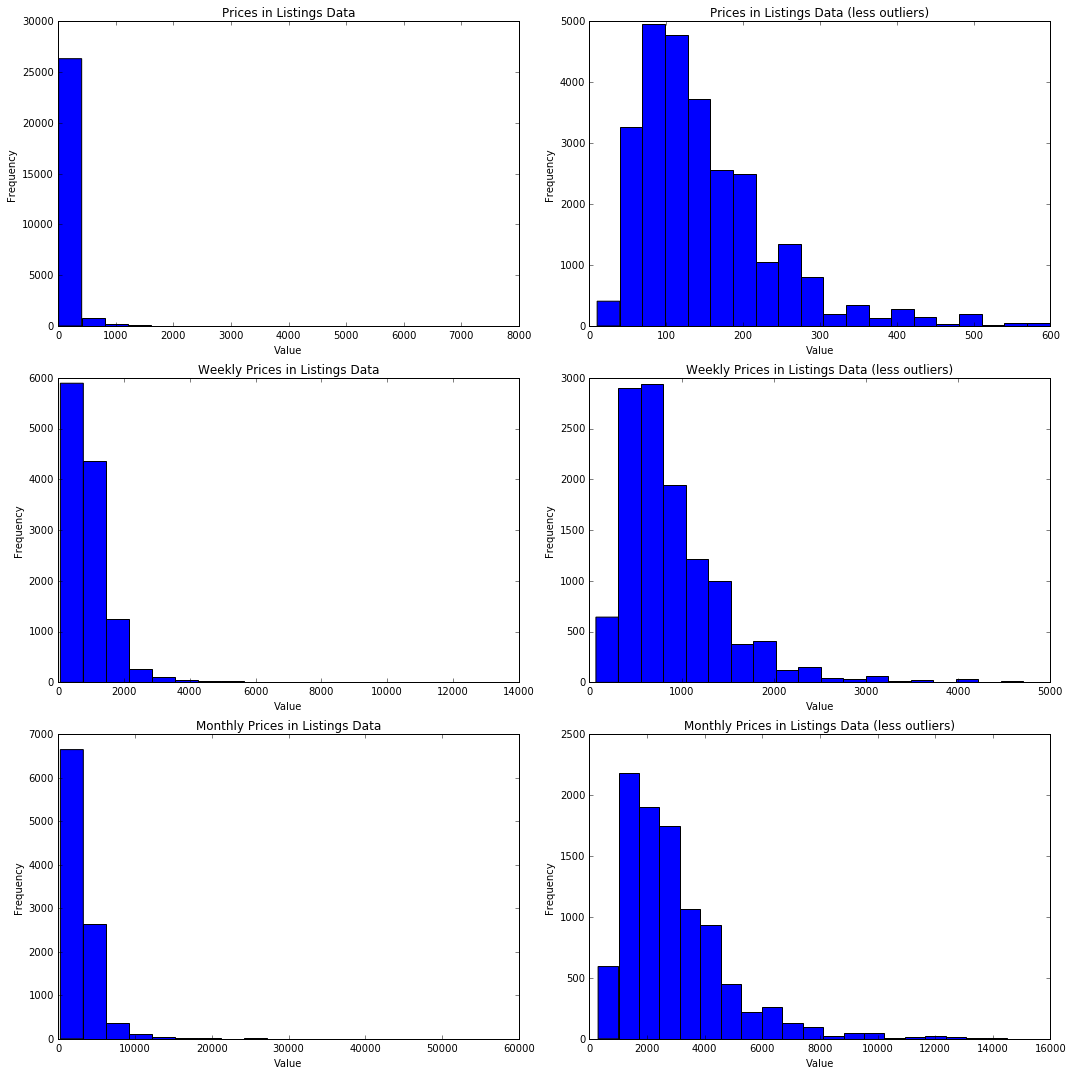

In [21]:
# np arrays for numerical series
price = [val for val in np.array(listings_df['price']) if ~np.isnan(val)]
weekly_price = [val for val in np.array(listings_df['weekly_price']) if ~np.isnan(val)]
monthly_price = [val for val in np.array(listings_df['monthly_price']) if ~np.isnan(val)]

# remove out outliers
price_out = [p for p in price if p < 600]
weekly_price_out = [p for p in weekly_price if p < 5000]
monthly_price_out = [p for p in monthly_price if p < 15000]

# price related variables
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0][0] = plot_histogram(price, 'Prices in Listings Data', ax[0][0], 20)
ax[0][1] = plot_histogram(price_out, 'Prices in Listings Data (less outliers)', ax[0][1], 20)

ax[1][0] = plot_histogram(weekly_price, 'Weekly Prices in Listings Data', ax[1][0], 20)
ax[1][1] = plot_histogram(weekly_price_out, 'Weekly Prices in Listings Data (less outliers)', ax[1][1], 20)

ax[2][0] = plot_histogram(monthly_price, 'Monthly Prices in Listings Data', ax[2][0], 20)
ax[2][1] = plot_histogram(monthly_price_out, 'Monthly Prices in Listings Data (less outliers)', ax[2][1], 20)
plt.tight_layout()
plt.show()

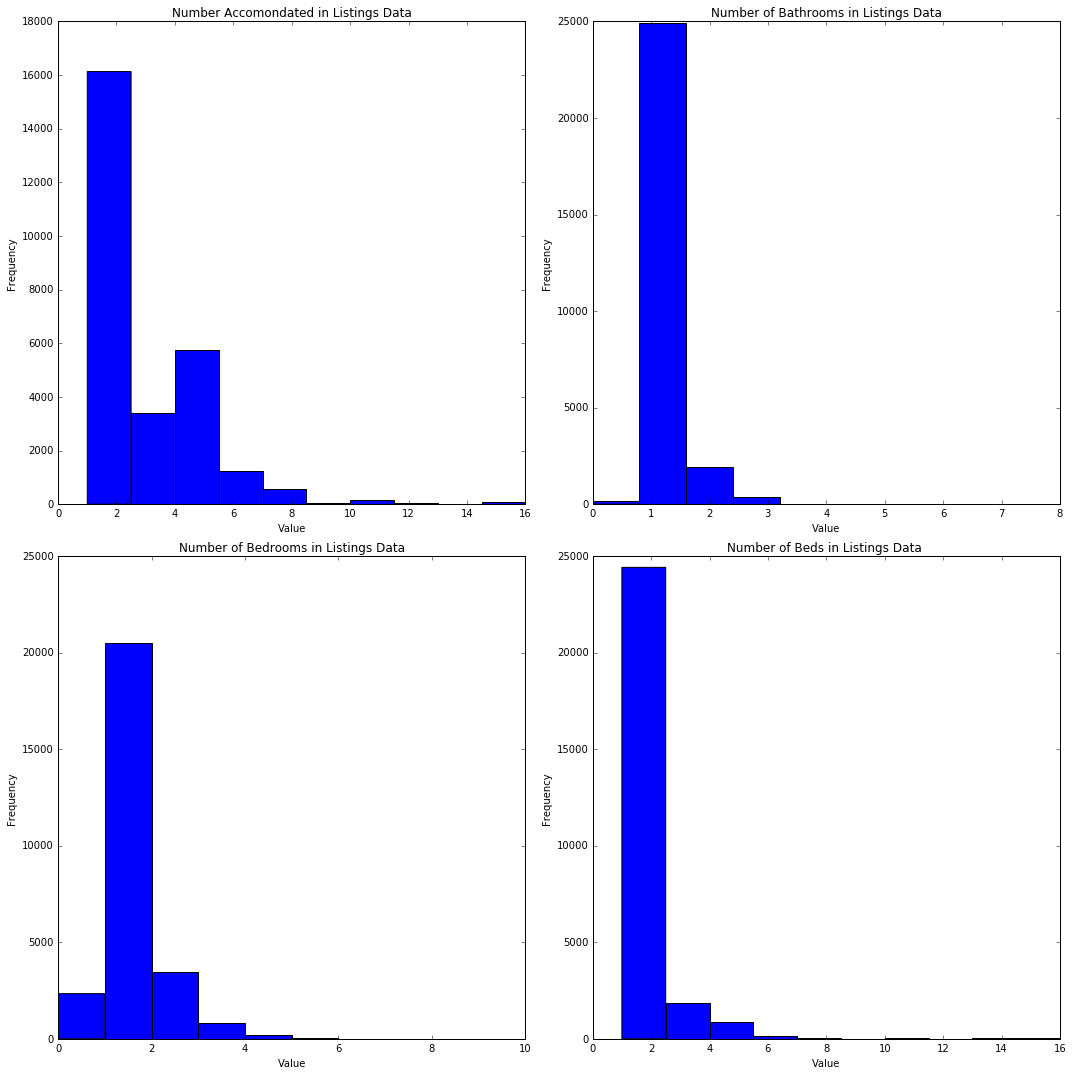

In [22]:
# accomodations related variables
accommodates = np.array(listings_df['accommodates'])
bathrooms = [val for val in np.array(listings_df['bathrooms']) if ~np.isnan(val)]
bedrooms = [val for val in np.array(listings_df['bedrooms']) if ~np.isnan(val)]
beds = [val for val in np.array(listings_df['beds']) if ~np.isnan(val)]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0][0] = plot_histogram(accommodates, 'Number Accomondated in Listings Data', ax[0][0], 10)
ax[0][1] = plot_histogram(bathrooms, 'Number of Bathrooms in Listings Data', ax[0][1], 10)

ax[1][0] = plot_histogram(bedrooms, 'Number of Bedrooms in Listings Data', ax[1][0], 10)
ax[1][1] = plot_histogram(beds, 'Number of Beds in Listings Data ', ax[1][1], 10)

plt.tight_layout()
plt.show()

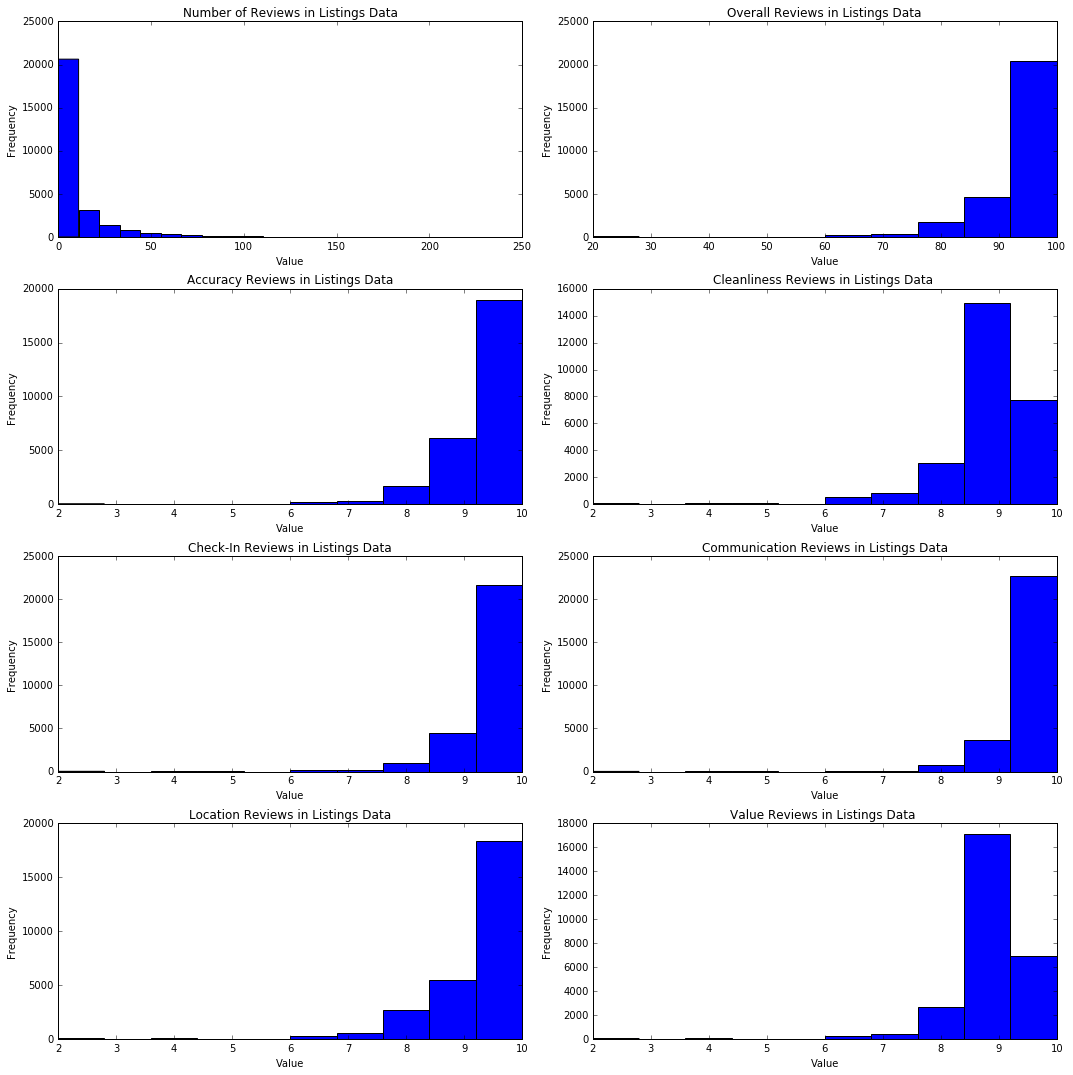

In [23]:
# reviews related variables
number_of_reviews = np.array(listings_df['number_of_reviews'])
review_scores_rating = [val for val in np.array(listings_df['review_scores_rating']) if ~np.isnan(val)]
review_scores_accuracy = [val for val in np.array(listings_df['review_scores_accuracy']) if ~np.isnan(val)]
review_scores_cleanliness = [val for val in np.array(listings_df['review_scores_cleanliness']) if ~np.isnan(val)]
review_scores_checkin = [val for val in np.array(listings_df['review_scores_checkin']) if ~np.isnan(val)]
review_scores_communication = [val for val in np.array(listings_df['review_scores_communication']) if ~np.isnan(val)]
review_scores_location = [val for val in np.array(listings_df['review_scores_location']) if ~np.isnan(val)]
review_scores_value = [val for val in np.array(listings_df['review_scores_value']) if ~np.isnan(val)]

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax[0][0] = plot_histogram(number_of_reviews, 'Number of Reviews in Listings Data', ax[0][0], 20)
ax[0][1] = plot_histogram(review_scores_rating, 'Overall Reviews in Listings Data', ax[0][1], 10)

ax[1][0] = plot_histogram(review_scores_accuracy, 'Accuracy Reviews in Listings Data', ax[1][0], 10)
ax[1][1] = plot_histogram(review_scores_cleanliness, 'Cleanliness Reviews in Listings Data ', ax[1][1], 10)

ax[2][0] = plot_histogram(review_scores_checkin, 'Check-In Reviews in Listings Data', ax[2][0], 10)
ax[2][1] = plot_histogram(review_scores_communication, 'Communication Reviews in Listings Data', ax[2][1], 10)

ax[3][0] = plot_histogram(review_scores_location, 'Location Reviews in Listings Data', ax[3][0], 10)
ax[3][1] = plot_histogram(review_scores_value, 'Value Reviews in Listings Data ', ax[3][1], 10)

plt.tight_layout()
plt.show()

In [24]:
# categorical geographical variables by examining most frequent entries
top_neighborhood = sorted(listings_df.groupby('neighbourhood').size().to_dict().items(), key=operator.itemgetter(1), reverse=True)
top_zipcode = sorted(listings_df.groupby('zipcode').size().to_dict().items(), key=operator.itemgetter(1), reverse=True)
top_property_type = sorted(listings_df.groupby('property_type').size().to_dict().items(), key=operator.itemgetter(1), reverse=True)

print 'Top Neighborhoods'
for k, v in top_neighborhood[:10]:
    print str(k) + ': ' + str(v)
    
print '\nTop Zipcodes'
for k, v in top_zipcode[:10]:
    print str(k) + ': ' + str(v)
    
print '\nTop Property Types'
for k, v in top_property_type[:10]:
    print str(k) + ': ' + str(v)

Top Neighborhoods
unspecified: 2027
Williamsburg: 1878
Upper West Side: 1307
Upper East Side: 1183
Hell's Kitchen: 1177
Bedford-Stuyvesant: 1112
Bushwick: 1023
Lower East Side: 942
Harlem: 861
East Village: 842

Top Zipcodes
11211: 1200
10002: 1130
10009: 1062
10003: 948
10011: 855
11238: 814
10014: 797
10019: 760
11216: 697
10012: 685

Top Property Types
Apartment: 24915
House: 1575
Loft: 601
Bed & Breakfast: 170
Dorm: 49
Other: 48
Boat: 11
Treehouse: 6
Villa: 4
Cabin: 3


### Correlations between price and features of home

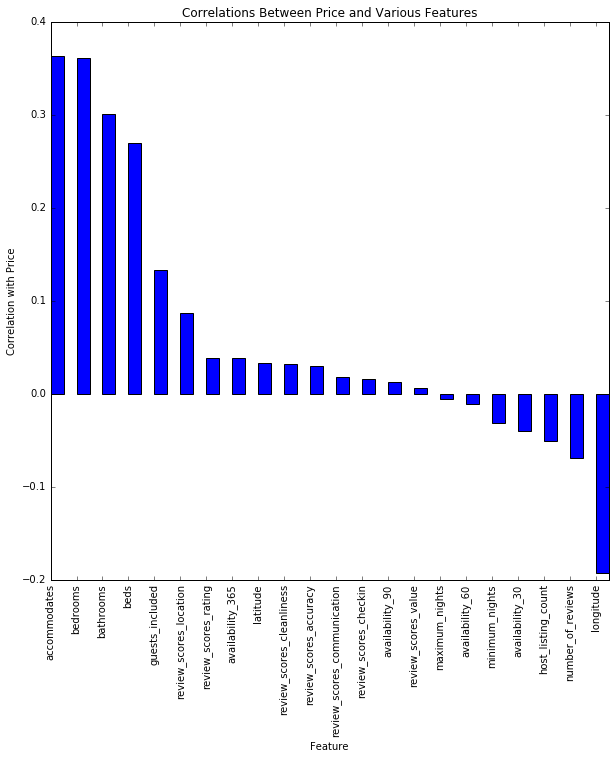

In [25]:
# get correlations on price
corrs_dict = (listings_df.corr())['price'].to_dict()

# delete irrelevant features
for var in ['price', 'weekly_price', 'monthly_price', 'scrape_id', 'host_id', 'listing_id']:
    del corrs_dict[var]

# sort by correlation value
price_corrs = sorted(corrs_dict.items(), key=operator.itemgetter(1), reverse=True)

# break into two lists
features, corrs = zip(*price_corrs)

# plot correlations
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_ylabel('Correlation with Price')
ax.set_xlabel('Feature')
ax.set_title('Correlations Between Price and Various Features')
plt.xticks(range(len(corrs)), features, rotation='vertical')
ax.bar(range(len(corrs)), corrs, .5, color="blue")
plt.show()

### Relationship between price and time

In [61]:
# method to convert date to day of week
def get_day(date):
    return datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A')

In [30]:
date_prices = {date: 0 for date in calendar_df['date'].unique()}
day_prices = {get_day(date): 0 for date in calendar_df['date'].unique()}
day_counts = {get_day(date): 0 for date in calendar_df['date'].unique()}

for date in calendar_df['date'].unique():
    prices = [p for p in np.array(calendar_df[calendar_df['date'] == date]['price']) if ~np.isnan(p)]
    date_prices[date] = np.mean(prices)
    day_prices[get_day(date)] += np.sum(prices)
    day_counts[get_day(date)] += len(prices)

In [31]:
for day, price_sum in day_prices.iteritems():
    day_prices[day] = float(day_prices[day]) / float(day_counts[day])

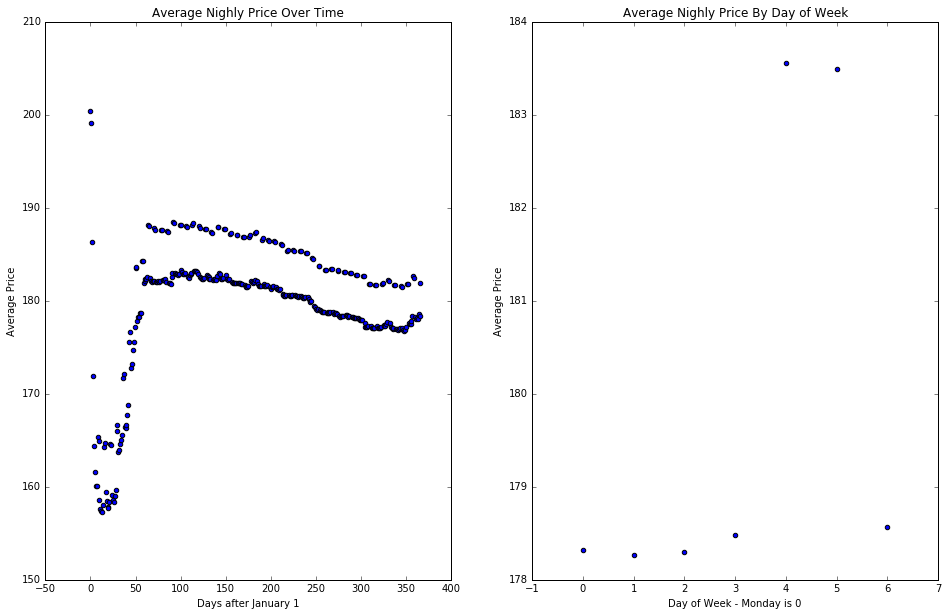

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ordered_date_prices = [value for key, value in sorted(date_prices.items())]
ax[0].scatter(range(367), ordered_date_prices)
ax[1].scatter(range(7), [day_prices['Monday'], day_prices['Tuesday'], day_prices['Wednesday'], day_prices['Thursday'], day_prices['Friday'], day_prices['Saturday'], day_prices['Sunday']])

# Label axes, set title
ax[0].set_title('Average Nighly Price Over Time')
ax[0].set_xlabel('Days after January 1')
ax[0].set_ylabel('Average Price')

ax[1].set_title('Average Nighly Price By Day of Week')
ax[1].set_xlabel('Day of Week - Monday is 0')
ax[1].set_ylabel('Average Price')

plt.show()

In [91]:
# dictionary to contain means
listing_means = {listing: 0 for listing in calendar_df['listing_id'].unique()}

# calculate mean prices for each listing
for listing in calendar_df['listing_id'].unique():
    listing_means[listing] = np.mean(calendar_df[calendar_df['listing_id'] == listing]['price'])
    
# convert to numpy for efficiency
prices = np.array(calendar_df['price'])
ids = np.array(calendar_df['listing_id'])
diff_means = []
for i in range(len(prices)):
    diff_means.append(prices[i] - listing_means[ids[i]])    

In [96]:
# calculate average difference from means over all listings
avg_diff_means = {date: 0 for date in calendar_df['date'].unique()}
for date, mean in avg_diff_means.iteritems():
    avg_diff_means[date] = np.mean(calendar_df[calendar_df['date'] == date]['diff_mean'])
    
# calculate average difference from means by day of week
# convert to numpy for speed
dates = np.array(calendar_df['date'])
day_avg_diff_means = {get_day(date): 0 for date in calendar_df['date'].unique()}
for i in range(len(prices)):
    day_avg_diff_means[get_day(dates[i])] += diff_means[i]
for day, avg_diff in day_avg_diff_means.iteritems():
    day_avg_diff_means[day] = float(day_avg_diff_means[day]) / float(day_counts[day])

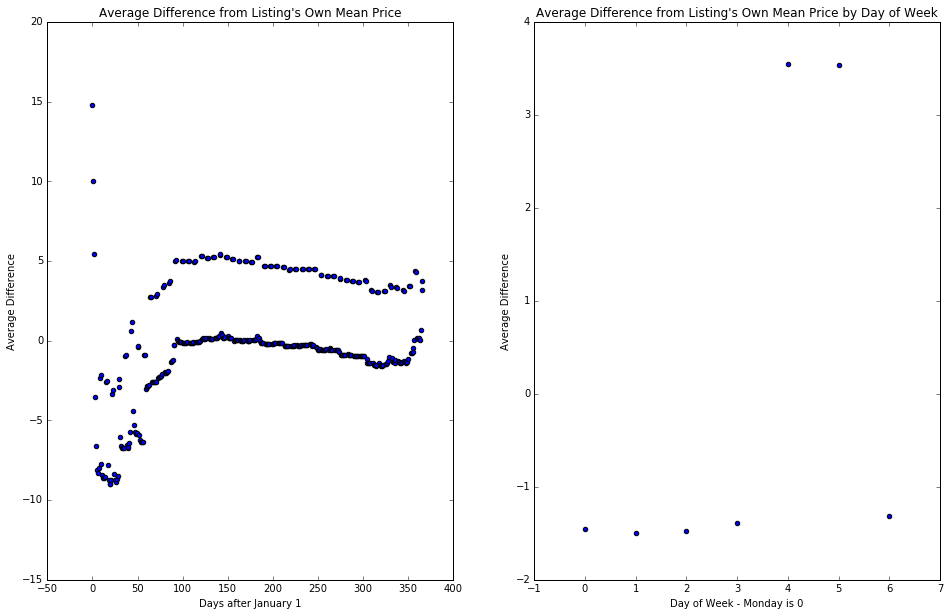

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ordered_avg_diff_means = [value for key, value in sorted(avg_diff_means.items())]
ax[0].scatter(range(367), ordered_avg_diff_means)
ax[1].scatter(range(7), [day_avg_diff_means['Monday'], day_avg_diff_means['Tuesday'], day_avg_diff_means['Wednesday'], day_avg_diff_means['Thursday'], day_avg_diff_means['Friday'], day_avg_diff_means['Saturday'], day_avg_diff_means['Sunday']])

# Label axes, set title
ax[0].set_title('Average Difference from Listing\'s Own Mean Price')
ax[0].set_xlabel('Days after January 1')
ax[0].set_ylabel('Average Difference')

ax[1].set_title('Average Difference from Listing\'s Own Mean Price by Day of Week')
ax[1].set_xlabel('Day of Week - Monday is 0')
ax[1].set_ylabel('Average Difference')

plt.show()

In [116]:
# examine priciest and cheapest dates
sorted_avg_diffs = sorted(avg_diff_means.items(), key=lambda x: x[1])
print 'Dates with lowest average differences from mean:'
for date, diff in sorted_avg_diffs[:15]:
    print date + ', ' + get_day(date) + ': $' + str(round(diff, 2))
    
print '\nDates with highest average differences from mean:'
for date, diff in sorted_avg_diffs[-15:]:
    print date + ', ' + get_day(date) + ': $' + str(round(diff, 2))

Dates with lowest average differences from mean:
2015-01-21, Wednesday: $-9.01
2015-01-20, Tuesday: $-8.99
2015-01-27, Tuesday: $-8.85
2015-01-22, Thursday: $-8.76
2015-01-26, Monday: $-8.76
2015-01-19, Monday: $-8.71
2015-01-28, Wednesday: $-8.68
2015-01-14, Wednesday: $-8.6
2015-01-13, Tuesday: $-8.59
2015-01-15, Thursday: $-8.55
2015-01-29, Thursday: $-8.48
2015-01-12, Monday: $-8.44
2015-01-25, Sunday: $-8.35
2015-01-07, Wednesday: $-8.3
2015-01-06, Tuesday: $-8.13

Dates with highest average differences from mean:
2015-05-08, Friday: $5.18
2015-05-09, Saturday: $5.19
2015-05-15, Friday: $5.22
2015-07-03, Friday: $5.23
2015-05-16, Saturday: $5.24
2015-05-29, Friday: $5.24
2015-05-30, Saturday: $5.24
2015-07-04, Saturday: $5.25
2015-05-02, Saturday: $5.29
2015-05-01, Friday: $5.29
2015-05-22, Friday: $5.39
2015-05-23, Saturday: $5.42
2015-01-03, Saturday: $5.44
2015-01-02, Friday: $10.0
2015-01-01, Thursday: $14.76


---

## Summary of Work and Insights
### Data Overview
#### Formatting
The data was retrieved from the data.beta.nyc website by zip file download. The only complication in storing the data is that since the file sizes are over 100MB, the files can not be stored on GitHub. If it proves necessary, GitHub Large File Storage may provide a solution for this issue.

In each of the three datasets, (listings, calendar, and reviews), the data are well formatted overall in CSV format with one record (listing, listing-date, or review, respectively) per row. Given the varied nature of the data, Pandas is a good choice for initial processing, and each of the three datasets is read into its own Pandas data frame. Manual examination of the data shows that the 'id' field in the listings data set corresponds to the 'listing_id' fields in the reviews and calendar data, so joining on these fields is feasible, as demonstrated in the proof of concept above.

There are occasional formatting irregularities throughout the data that have been fixed. For example, some fields contained excess parentheses or string data types where floats or booleans are more appropriate. The price fields were orignally encoded as strings with dollar sign and comma values. These were converted to floats for use in learning models. 

#### Missing Values
While the datasets are very complete on average, there are a significant number of missing values. In the listings dataset, roughly 30% of all review scores, the vast majority of the square footage values, and low percentages of other listing characteristics are missing. In the calendar dataset, 28% of the listing-dates do not have price information. In the reviews dataset, an insignificant number of comments are missing.

The missing values were handled in various ways to suit the nature of the data. Missing price data is a roadblock because it is inadvisable to attempt to impute missing response variables. Thus, records with missing price data are dropped. For categorical variables, it is imagninable that knowing which listings have descriptors absent is associated with the price (likely in a negative fashion). Therefore, missing categorical values were replaced with a new category 'unspecified'. Missing review values were imputed with the global mean, as the correlation between price and the majority of review metrics is so low that attempting to use regression for imputation would be useless. Likewise, the data are too noisy for KNN to be of use. For other continuous feature variables such as bedrooms, bathrooms, and beds with relatively high correlation with price, missing values were imputed using linear regression. 

After all imputation was finished, the only missing values were those of weekly and monthly prices. These missing values are potential response variables, and will be dealt with on an individual model basis.


#### Size of Data
There are a total of about 27,000 listings in the listings data set, each with 52 features. The calendar dataset contains one entry for each day of the year for each of the approximately 27,000 listings. The reviews dataset contains about 28,000 reviews for about 19,000 distinct listings. 

After cleaning, the majority of the data remains. All of the orignal listings remain in the data; over 70% of the calendar records are useful; and the vast majority of the reviews have complete comments.

### Features and their Distributions
There are three potential response variables in the data, nighly price, weekly price, and mothly price. Since over half of the weekly and monthly price data are not present, it seems reasonable to focus on predicting nightly price. Nightly prices are right-skewed, with a few very high outliers. The majority of the prices are below 300 dollars per night. The price distribution looks approximately lognormal, so a log transformation of the price variable resulting in a normal distribution of prices may play better with regression techniques.

There are over fifty predictors in the listings dataset, both continuous and categorical. Histograms of the continuous variables of interest and lists of the most frequent categorical variables of interest appear above. Interesting factors to note are that the majority of listings have one bedroom and one bathroom, and that reviews are extremely left-skewed.

### Correlations between Price and Features
The Pearson correlations between price and each feature variable of interest is plotted above in decreasing order of correlation. From the chart, we see that the basic physical features of the listings are most strongly linearly related with price: number of individuals accomodated, number of beds and bedrooms, and number of bathrooms have the highest correlation values. The strongest negative linear relationships with price are for the number of listings by the given host, number of reviews, and the longitude of the listing. These results all make intuitive sense. Hosts with many listings may be less attentive to their tenants, tenants may be more inclined to leave a negative review, and knowledge of the demographics of New York supports the observed negative relationship between price and longitude.

While studying these correlation values are useful, they only describe the magnitude of the linear relationship between price and the predictors, so additional visual anlaysis is necessary.

### Relationship between Price and Time
There are strong and interestings relationships between the prices of listings and both the time of year and the day of the week. Two different sets of statistics were computed to investigate these relationships. First, the simple average price over all the listings was calculated for each day of the year, and for each day of the week. Since this may overlook certain patterns, the differences between the price of a property on each day of the year and its average price throughout the year was also calculated, and averaged accross all the properties for each day of the year. 

Both sets of metrics show very similar trends. Late in the month of January is very cheap: all of the fifteen dates with the largest negative average difference from mean listing price occurred in the month of January. Most dates are up to 8 dollars cheaper on average. In striking contrast, early January (presumably because of New Years celebrations) are the most expensive, with the first few days averaging over 10 dollars more expensive than usual. The spring and early summer months are also more expensive by about 5 dollars on average for peak times. 

The relationship between the day of the week and the average difference in listing price from its mean is also very strong. Weekdays and Sunday are all similarly priced. However, Fridays and Saturdays average 3.50 dollars more expensive than weeknights.

In the modelling stage, it is clear that time (in terms of both date and day of the week) will be an important feature. The interaction between the date and day of the week may also prove helpful.